In [ ]:
! pip install datasets
! pip install -U accelerate
! pip install -U transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 22.1 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.35.2
    Uninstalling transformers-4.35.2:
      Successfully uninstalled transformers-4.35.2


In [ ]:
import torch
import numpy as np
import os
import datetime
from copy import deepcopy

from transformers import (RobertaTokenizer,
                          RobertaForSequenceClassification,
                          Trainer,
                          TrainingArguments,
                          TrainerCallback)
from datasets import (load_dataset,
                      load_metric,
                      load_dataset_builder,
                      ClassLabel,
                      Value,
                      Features)

import argparse
import os

import torch
from torch.optim import AdamW
from torch.utils.data import DataLoader
from peft import (
    get_peft_config,
    get_peft_model,
    get_peft_model_state_dict,
    set_peft_model_state_dict,
    LoraConfig,
    PeftType,
    PrefixTuningConfig,
    PromptEncoderConfig,
)

from datasets import load_dataset
from transformers import AutoModelForSequenceClassification, AutoTokenizer, get_linear_schedule_with_warmup, set_seed
from tqdm import tqdm

BATCH_SIZE = 32


DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda:0


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


{'premise': Value(dtype='string', id=None),
 'hypothesis': Value(dtype='string', id=None),
 'label': ClassLabel(names=['entailment', 'neutral', 'contradiction'], id=None),
 'idx': Value(dtype='int32', id=None)}

In [ ]:
train_data, val_m_data, val_mm_data = load_dataset("glue", "mnli", split=['train', 'validation_matched', 'validation_mismatched'])

print("Train dataset:\n", train_data)
print("Validation matched dataset:\n", val_m_data)
print("Validation mismatched dataset:\n", val_mm_data)
metric = load_metric('glue', "mnli")


Train dataset:
 Dataset({
    features: ['premise', 'hypothesis', 'label', 'idx'],
    num_rows: 392702
})
Validation matched dataset:
 Dataset({
    features: ['premise', 'hypothesis', 'label', 'idx'],
    num_rows: 9815
})
Validation mismatched dataset:
 Dataset({
    features: ['premise', 'hypothesis', 'label', 'idx'],
    num_rows: 9832
})


/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for glue contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/glue/glue.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [ ]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', do_lower_case=True)
def tokenize_function(examples):
    return tokenizer(examples["premise"], examples["hypothesis"], padding="max_length",max_length=128, truncation=True)

train_data = train_data.shuffle(seed=42).select(range(1000))
val_m_data = val_m_data.shuffle(seed=42).select(range(1000))

train_data = train_data.map(tokenize_function, batched=True)
val_m_data = val_m_data.map(tokenize_function, batched=True)
val_mm_data = val_mm_data.map(tokenize_function, batched=True)
train_data.set_format('torch', columns=["input_ids", "attention_mask", "label"])
val_m_data.set_format('torch', columns=["input_ids", "attention_mask", "label"])
val_mm_data.set_format('torch', columns=["input_ids", "attention_mask", "label"])

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


In [ ]:
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=3)
model.to(DEVICE)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [ ]:
metric_name = "accuracy"

args = TrainingArguments(
    output_dir = "Fine_tuned_Roberta",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    resume_from_checkpoint=True,
)


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
class CustomCallback(TrainerCallback):

    def __init__(self, trainer) -> None:
        super().__init__()
        self._trainer = trainer

    def on_epoch_end(self, args, state, control, **kwargs):
        if control.should_evaluate:
            control_copy = deepcopy(control)
            self._trainer.evaluate(eval_dataset=self._trainer.train_dataset, metric_key_prefix="train")
            return control_copy


trainer = Trainer(
    model,
    args,
    train_dataset=train_data, #tokenized_train_data,
    eval_dataset=val_m_data,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

#trainer.add_callback(CustomCallback(trainer))


trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.106683,0.328000
2,No log,1.090447,0.446000
3,No log,1.015701,0.488000
4,No log,1.002251,0.531000
5,No log,0.955415,0.557000


Checkpoint destination directory Fine_tuned_Roberta/checkpoint-32 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory Fine_tuned_Roberta/checkpoint-64 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory Fine_tuned_Roberta/checkpoint-96 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory Fine_tuned_Roberta/checkpoint-128 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory Fine_tuned_Roberta/checkpoint-160 already exists and is non-empty.Saving will proceed but saved results may be invalid.


TrainOutput(global_step=160, training_loss=0.9854669570922852, metrics={'train_runtime': 164.0284, 'train_samples_per_second': 30.483, 'train_steps_per_second': 0.975, 'total_flos': 328891772160000.0, 'train_loss': 0.9854669570922852, 'epoch': 5.0})

In [ ]:
# Assuming you have a test dataset named test_data
test_results = trainer.evaluate(val_mm_data)

# Print or use the evaluation results as needed
print("Evaluation Results:", test_results)

Evaluation Results: {'eval_loss': 0.9747503399848938, 'eval_accuracy': 0.5093572009764036, 'eval_runtime': 63.516, 'eval_samples_per_second': 154.796, 'eval_steps_per_second': 4.849, 'epoch': 5.0}


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Assuming you have already initialized the model, tokenizer, and defined the training arguments
# model = ...
# tokenizer = ...
# args = ...

# Assuming you have a test dataset named test_data
test_results = trainer.predict(val_mm_data)

# Get predicted labels and true labels
predicted_labels = np.argmax(test_results.predictions, axis=1)
true_labels = val_mm_data["label"]  # Replace "label" with the actual label column name in your test dataset

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Print or display the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# You can also print a classification report for additional metrics
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels))


Confusion Matrix:
[[2486  728  249]
 [ 594 2102  433]
 [ 700 1142 1398]]

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.72      0.69      3463
           1       0.53      0.67      0.59      3129
           2       0.67      0.43      0.53      3240

    accuracy                           0.61      9832
   macro avg       0.62      0.61      0.60      9832
weighted avg       0.62      0.61      0.60      9832



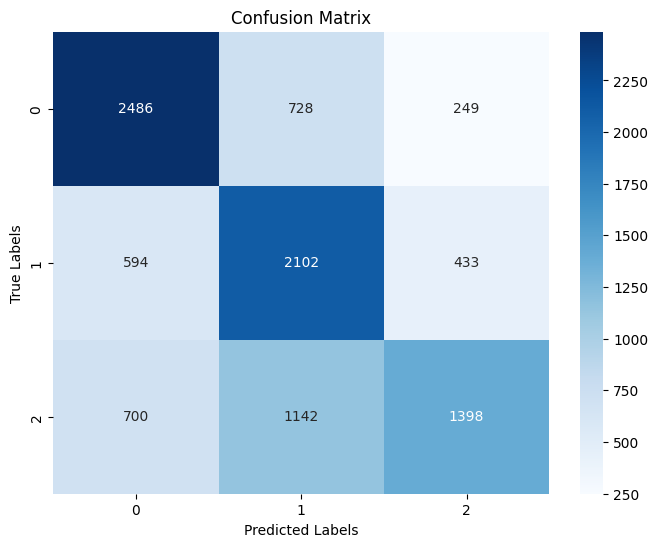

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Freeze Roberta

In [ ]:
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=3)
# Freeze the pre-trained weights
# Freeze all layers except the classifier
num_layers_to_freeze = 6

# Freeze the layers
for param in model.roberta.embeddings.parameters():
    param.requires_grad = False

for i in range(num_layers_to_freeze):
    for param in model.roberta.encoder.layer[i].parameters():
        param.requires_grad = False
model.to(DEVICE)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [ ]:
# Assuming 'model' is your RoBERTa model
for name, param in model.named_parameters():
    print(f'{name}: requires_grad={param.requires_grad}')


roberta.embeddings.word_embeddings.weight: requires_grad=False
roberta.embeddings.position_embeddings.weight: requires_grad=False
roberta.embeddings.token_type_embeddings.weight: requires_grad=False
roberta.embeddings.LayerNorm.weight: requires_grad=False
roberta.embeddings.LayerNorm.bias: requires_grad=False
roberta.encoder.layer.0.attention.self.query.weight: requires_grad=False
roberta.encoder.layer.0.attention.self.query.bias: requires_grad=False
roberta.encoder.layer.0.attention.self.key.weight: requires_grad=False
roberta.encoder.layer.0.attention.self.key.bias: requires_grad=False
roberta.encoder.layer.0.attention.self.value.weight: requires_grad=False
roberta.encoder.layer.0.attention.self.value.bias: requires_grad=False
roberta.encoder.layer.0.attention.output.dense.weight: requires_grad=False
roberta.encoder.layer.0.attention.output.dense.bias: requires_grad=False
roberta.encoder.layer.0.attention.output.LayerNorm.weight: requires_grad=False
roberta.encoder.layer.0.attention.

In [ ]:
metric_name = "accuracy"

args = TrainingArguments(
    output_dir = "Fine_tuned_Roberta",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    resume_from_checkpoint=True,
)


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
class CustomCallback(TrainerCallback):

    def __init__(self, trainer) -> None:
        super().__init__()
        self._trainer = trainer

    def on_epoch_end(self, args, state, control, **kwargs):
        if control.should_evaluate:
            control_copy = deepcopy(control)
            self._trainer.evaluate(eval_dataset=self._trainer.train_dataset, metric_key_prefix="train")
            return control_copy


trainer = Trainer(
    model,
    args,
    train_dataset=train_data, #tokenized_train_data,
    eval_dataset=val_m_data,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

#trainer.add_callback(CustomCallback(trainer))


trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.105728,0.328000
2,No log,1.097146,0.366000
3,No log,1.063065,0.451000
4,No log,1.054658,0.450000
5,No log,1.011699,0.480000


Checkpoint destination directory Fine_tuned_Roberta/checkpoint-32 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory Fine_tuned_Roberta/checkpoint-64 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory Fine_tuned_Roberta/checkpoint-96 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory Fine_tuned_Roberta/checkpoint-128 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory Fine_tuned_Roberta/checkpoint-160 already exists and is non-empty.Saving will proceed but saved results may be invalid.


TrainOutput(global_step=160, training_loss=1.0496860504150392, metrics={'train_runtime': 173.2964, 'train_samples_per_second': 28.852, 'train_steps_per_second': 0.923, 'total_flos': 328891772160000.0, 'train_loss': 1.0496860504150392, 'epoch': 5.0})

In [ ]:
# Assuming you have a test dataset named test_data
test_results = trainer.evaluate(val_m_data)

# Print or use the evaluation results as needed
print("Evaluation Results:", test_results)

Evaluation Results: {'eval_loss': 1.0116990804672241, 'eval_accuracy': 0.48, 'eval_runtime': 6.3963, 'eval_samples_per_second': 156.342, 'eval_steps_per_second': 5.003, 'epoch': 5.0}


In [ ]:
# Assuming you have a test dataset named test_data
test_results = trainer.evaluate(val_mm_data)

# Print or use the evaluation results as needed
print("Evaluation Results:", val_m_data)

Evaluation Results: Dataset({
    features: ['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'attention_mask'],
    num_rows: 1000
})


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Assuming you have already initialized the model, tokenizer, and defined the training arguments
# model = ...
# tokenizer = ...
# args = ...

# Assuming you have a test dataset named test_data
test_results = trainer.predict(val_mm_data)

# Get predicted labels and true labels
predicted_labels = np.argmax(test_results.predictions, axis=1)
true_labels = val_mm_data["label"]  # Replace "label" with the actual label column name in your test dataset

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Print or display the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# You can also print a classification report for additional metrics
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels))


Confusion Matrix:
[[2478  915   70]
 [ 860 2226   43]
 [1029 1907  304]]

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.72      0.63      3463
           1       0.44      0.71      0.54      3129
           2       0.73      0.09      0.17      3240

    accuracy                           0.51      9832
   macro avg       0.58      0.51      0.45      9832
weighted avg       0.58      0.51      0.45      9832



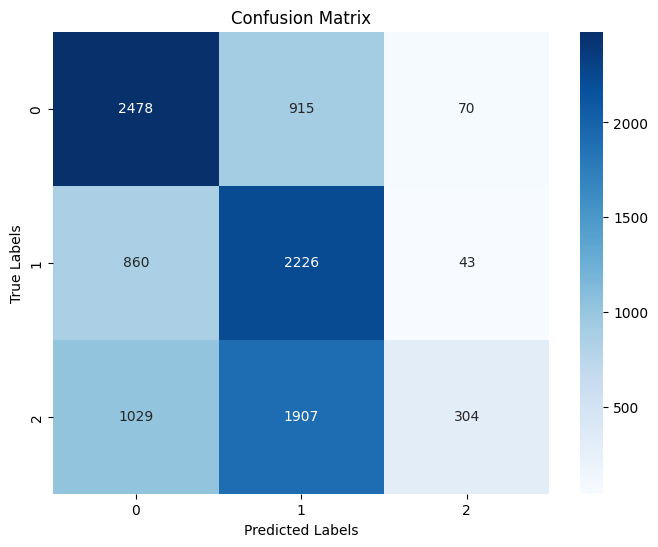

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Peft

In [ ]:
!pip install peft

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.3/168.3 kB 4.0 MB/s eta 0:00:00


In [ ]:
from peft import LoraConfig, TaskType

batch_size = 32
model_name_or_path = "roberta-large"
peft_type = PeftType.LORA
device = "cuda"
peft_config = LoraConfig(task_type=TaskType.SEQ_CLS, r=32, lora_alpha=16, lora_dropout=0.1)
lr = 3e-4

pretrained_model = RobertaForSequenceClassification.from_pretrained(model_name_or_path, return_dict=True,num_labels=3)

trainable_params = 0
all_param = 0
for _, param in pretrained_model.named_parameters():
    all_param += param.numel()
    if param.requires_grad:
        trainable_params += param.numel()
print(f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}")

model = get_peft_model(pretrained_model, peft_config)


trainable_params = 0
all_param = 0
for _, param in model.named_parameters():
    all_param += param.numel()
    if param.requires_grad:
        trainable_params += param.numel()
print(f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}")


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 355362819 || all params: 355362819 || trainable%: 100.0
trainable params: 4198403 || all params: 359561222 || trainable%: 1.167646215197255


In [ ]:
import torch
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the specified device
model.to(device)

# Create the dataloaders
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_m_data, batch_size=16, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(val_mm_data, batch_size=16, shuffle=False)

# Set up the optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=5e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=10000, num_training_steps=len(train_dataloader) * 10)
optimizer = AdamW(params=model.parameters(), lr=lr)

# Instantiate scheduler
num_epochs=5
lr_scheduler = get_linear_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=0.06 * (len(train_dataloader) * num_epochs),
    num_training_steps=(len(train_dataloader) * num_epochs),
)
metric = load_metric('glue', "mnli")

model.to(device)
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for step, batch in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch} - Training")):
        input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['label'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        train_loss += loss.item()
        _, predicted = outputs.logits.max(1)
        total_train += labels.size(0)
        correct_train += predicted.eq(labels).sum().item()

    avg_train_loss = train_loss / len(train_dataloader)
    train_accuracy = correct_train / total_train

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    for step, batch in enumerate(tqdm(val_dataloader, desc=f"Epoch {epoch} - Validation")):
        with torch.no_grad():
            input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['label'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

        loss = outputs.loss
        val_loss += loss.item()

        _, predicted = outputs.logits.max(1)
        total_val += labels.size(0)
        correct_val += predicted.eq(labels).sum().item()

    avg_val_loss = val_loss / len(val_dataloader)
    val_accuracy = correct_val / total_val

    print(f"Epoch {epoch}:")
    print(f"  Train Loss: {avg_train_loss:.4f} | Train Accuracy: {train_accuracy * 100:.2f}%")
    print(f"  Val Loss: {avg_val_loss:.4f} | Val Accuracy: {val_accuracy * 100:.2f}%")

/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for glue contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/glue/glue.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
Epoch 0 - Validation: 100%|██████████| 63/63 [00:22<00:00,  2.76it/s]


Epoch 0:
  Train Loss: 1.1168 | Train Accuracy: 34.80%
  Val Loss: 1.1050 | Val Accuracy: 32.90%


Epoch 1 - Validation: 100%|██████████| 63/63 [00:23<00:00,  2.73it/s]


Epoch 1:
  Train Loss: 1.1011 | Train Accuracy: 40.50%
  Val Loss: 1.0464 | Val Accuracy: 44.10%


Epoch 2 - Validation: 100%|██████████| 63/63 [00:23<00:00,  2.74it/s]


Epoch 2:
  Train Loss: 0.9522 | Train Accuracy: 54.00%
  Val Loss: 0.8100 | Val Accuracy: 64.80%


Epoch 3 - Validation: 100%|██████████| 63/63 [00:23<00:00,  2.74it/s]


Epoch 3:
  Train Loss: 0.6782 | Train Accuracy: 72.30%
  Val Loss: 0.7127 | Val Accuracy: 71.80%


Epoch 4 - Validation: 100%|██████████| 63/63 [00:22<00:00,  2.74it/s]

Epoch 4:
  Train Loss: 0.5212 | Train Accuracy: 79.70%
  Val Loss: 0.7106 | Val Accuracy: 73.00%


Test Set: 100%|██████████| 615/615 [03:46<00:00,  2.71it/s]


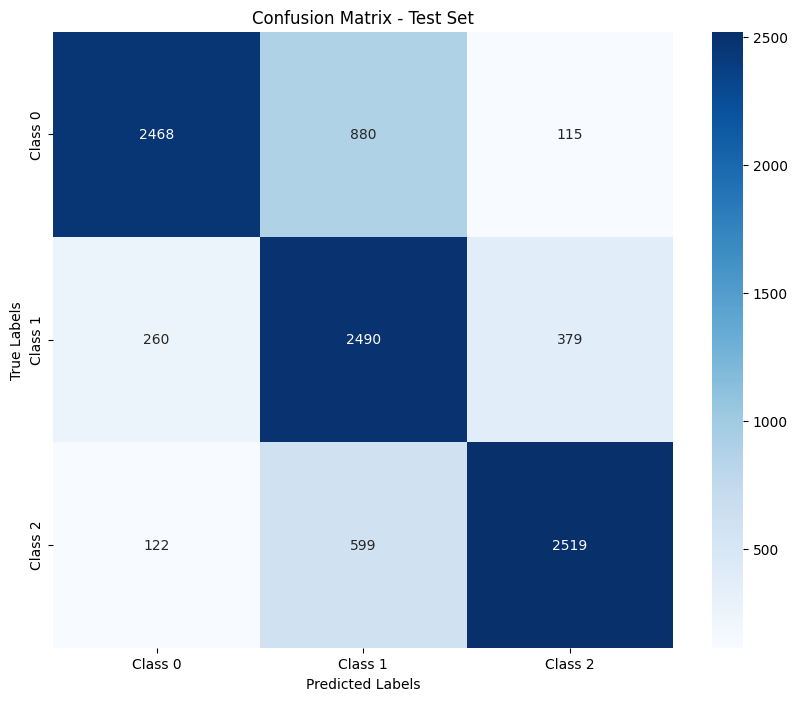

Test Accuracy: 0.7605


In [ ]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ...

# Training loop

# Validation loop

# Test set evaluation
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for step, batch in enumerate(tqdm(test_dataloader, desc="Test Set")):
        input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['label'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        predictions = outputs.logits.argmax(dim=-1)

        # Accumulate predictions and labels for the confusion matrix
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy for the test set
test_accuracy = accuracy_score(all_predictions, all_labels)

# Calculate and display the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2'], yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Test Set')
plt.show()

print(f"Test Accuracy: {test_accuracy:.4f}")


In [ ]:
from sklearn.metrics import classification_report
classification_report_str = classification_report(all_labels, all_predictions, target_names=['Class 0', 'Class 1', 'Class 2'])

print("Classification Report - Test Set:")
print(classification_report_str)
print(f"Test Accuracy: {test_accuracy:.4f}")

Classification Report - Test Set:
              precision    recall  f1-score   support

     Class 0       0.87      0.71      0.78      3463
     Class 1       0.63      0.80      0.70      3129
     Class 2       0.84      0.78      0.81      3240

    accuracy                           0.76      9832
   macro avg       0.78      0.76      0.76      9832
weighted avg       0.78      0.76      0.76      9832

Test Accuracy: 0.7605
